In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # for gradient warning (variables are still updated, therefore supressing is fine)
import tensorflow_probability as tfp 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

color_list = ['#bcad', '#dacb']

### Define the dataset 

(-2.0, 2.0)

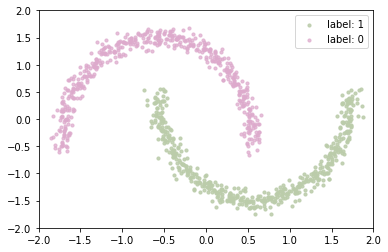

In [2]:
np.random.seed(42)

n_samples = 1000
niosy_moons = make_moons(n_samples=n_samples, noise=.05)
X, y = niosy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

y_label = y.astype(np.bool)
X_train, Y_train = X_data[...,0], X_data[...,1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color=color_list[0])
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color=color_list[1])
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

### Define prior distribution

In [3]:
def get_prior(num_modes, latent_dim):
    
    mixture_distribution = tfd.Categorical(probs=[1./num_modes] * num_modes)
    components_distribution = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal((num_modes, latent_dim))),
                                                        scale_diag=tfp.util.TransformedVariable(tf.ones((num_modes,latent_dim)),
                                                                                               bijector=tfb.Softplus())
                                                        )
    prior = tfd.MixtureSameFamily(mixture_distribution,
                                  components_distribution
                                 )
    return prior

In [4]:
latent_dim = 2
input_shape = 2

prior = get_prior(num_modes=latent_dim, latent_dim=latent_dim) 
print(f'Prior event shape: {prior.event_shape[0]}')
print(f'# of Gaussions: {prior.components_distribution.batch_shape[0]}') 
print(f'Covariance matrix: {prior.components_distribution.name}')

Prior event shape: 2
# of Gaussions: 2
Covariance matrix: MultivariateNormalDiag


### Define KL divergence

In [5]:
# set weight for more emphasis on KLDivergence term rather than reconstruction loss
# average over both samples and batches

def get_KL_regularizer(prior, weight=4.):
    
    regularizer = tfpl.KLDivergenceRegularizer(prior, 
                                        use_exact_kl=False,
                                        test_points_reduce_axis=(),
                                        test_points_fn=lambda q: q.sample(10),
                                        weight=weight
                                        )
    return regularizer

In [6]:
KLDivergence_regularizer = get_KL_regularizer(prior)

### Define the encoder

In [7]:
def get_encoder(input_shape, latent_dim, KL_regularizer):
    
    encoder = Sequential([
        Dense(input_shape=input_shape, units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, 
                                   activity_regularizer=KL_regularizer),
    ])
    
    return encoder

In [8]:
encoder = get_encoder(input_shape=(2,), latent_dim=latent_dim, KL_regularizer=KLDivergence_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8         
Total params: 44,173
Trainable params: 44,173
Non-trainable params: 0
____________________________________________________

### Define the decoder 

In [9]:
def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(input_shape=(latent_dim,), units=5, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim)
    ])
    
    return decoder

In [10]:
decoder = get_decoder(latent_dim)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
_________________________________________________________________
multivariate_normal_tri_l_1  multiple                  0         
Total params: 43,028
Trainable params: 43,028
Non-trainable params: 0
__________________________________________________

### Connect encoder to decoder 

In [11]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8     

### Specify the loss function 

In [12]:
# KL divergence is implicity incorporated to the loss function before
# add reconstruction error to loss function 
def reconstruction_error(decoding_dist, x_true):
    return -tf.reduce_mean(decoding_dist.log_prob(x_true))

class custom_reconstruction_error(Loss):
    def call(self, decoding_dist, x_true):
        return -tf.reduce_mean(decoding_dist.log_prob(x_true))

### Define training and validation sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, 
                                                    shuffle=True, stratify=y,
                                                    random_state=42)
print(f'# of training samples: {X_train.shape[0]}')
print(f'# of test samples: {X_test.shape[0]}')

# of training samples: 750
# of test samples: 250


### Visualize validation set

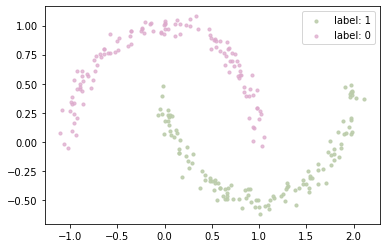

In [14]:
X_valid, Y_valid = X_test[...,0], X_test[...,1]
plt.scatter(X_valid[y_test == True], Y_valid[y_test == True], s=10, color=color_list[0])
plt.scatter(X_valid[y_test == False], Y_valid[y_test == False], s=10, color=color_list[1])
plt.legend(['label: 1', 'label: 0'])
plt.show()

### Compile and fit the model 

In [15]:
optimizer = Adam(learning_rate=3e-4)
epochs = 100 
epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print('\n Epoch {}/{}'.format(epoch+1, epochs, logs),
                                                                       '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                if epoch % 50 == 0 else False
                               )


vae.compile(optimizer=optimizer, loss=reconstruction_error)
history = vae.fit(X_train, 
                  validation_data=(X_test,),
                  epochs=epochs, 
                  batch_size=32,
                  verbose=0,
                  shuffle=True,
                  callbacks=[epoch_callback]
                 )


 Epoch 1/100 
	 loss: 23.1562, val_loss: 14.0041

 Epoch 51/100 
	 loss: 0.1843, val_loss: 0.1066


### Plot training and validation losses 

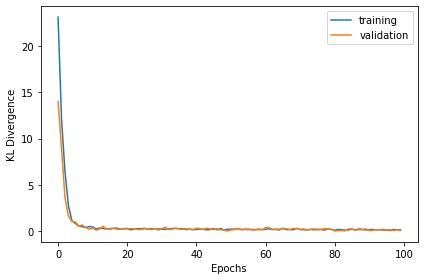

In [16]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.show()

# Loss function is ELBO maximization
# ELBO maximization is proportional to KL divergence minimization 

### Sample from the generative model

In [17]:
my_sample = np.concatenate((X_valid, Y_valid)).reshape(2, -1).transpose()
sampled = encoder(my_sample).sample()

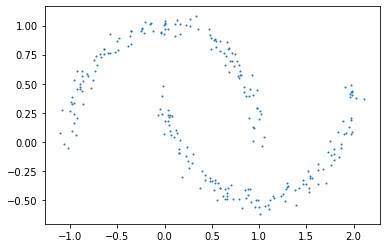

In [18]:
plt.scatter(my_sample[...,0], my_sample[..., 1], label='sampled', s=1)
plt.show()

## learns the distribution very well

### Inverse Masked Autoregressive Flow

In [19]:
loc = [my_sample[..., 0].mean().astype('float32'), my_sample[..., 1].mean().astype('float32')]
scale_diag = [my_sample[..., 0].std().astype('float32'), my_sample[..., 1].std().astype('float32')]

In [20]:
mvn = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [21]:
def masked_autoregressive_flow(hidden_units=[16,16], event_shape=[2], activation='relu'):
    network = tfb.AutoregressiveNetwork(params=2, 
                                    hidden_units=hidden_units,
                                    event_shape=event_shape,
                                    activation=activation
                                   )
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=network)

In [22]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                             bijector=tfb.Invert(masked_autoregressive_flow(
                                             activation='sigmoid')))
trainable_dist

<tfp.distributions.TransformedDistribution 'invert_masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [23]:
x = mvn.sample(sample_shape=(n_samples))
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [24]:
def _plot(results, rows=1, legend=False, plot_color: str=color_list[0]):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color=plot_color)
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

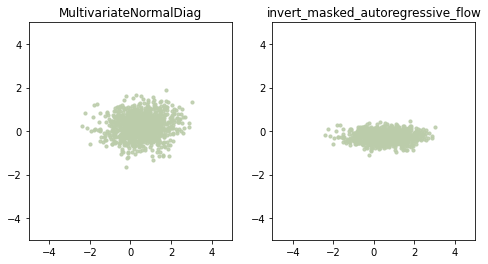

In [25]:
_plot(samples)

In [26]:
X_train, y_train = X_train.astype(np.float32), y_train.astype(np.float32)
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(128)

X_valid, y_valid = X_test.astype(np.float32), y_test.astype(np.float32)
X_valid = tf.data.Dataset.from_tensor_slices(X_valid)
X_valid = X_valid.batch(128)

In [27]:
num_epochs = 600
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 50 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 50...
Epoch 100...
Epoch 150...
Epoch 200...
Epoch 250...
Epoch 300...
Epoch 350...
Epoch 400...
Epoch 450...
Epoch 500...
Epoch 550...


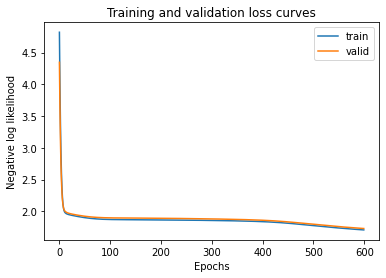

In [28]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [29]:
x = mvn.sample(sample_shape=n_samples)
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

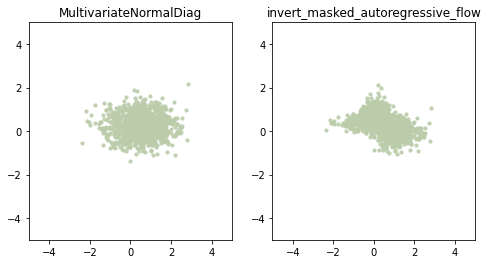

In [30]:
_plot(samples, rows=1)

In [31]:
num_layers = 4
flow_bijector = []

for i in range(num_layers):
    flow_i = masked_autoregressive_flow(hidden_units=[256,256])
    flow_bijector.append(flow_i) 
    flow_bijector.append(tfb.Permute([1,0]))
# discard the last permute layer 
flow_bijector = tfb.Chain(list(reversed(flow_bijector[:-1])))

In [32]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                            bijector=flow_bijector)

In [33]:
def make_samples():
    x = mvn.sample(n_samples)
    samples = [x]
    names = [mvn.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

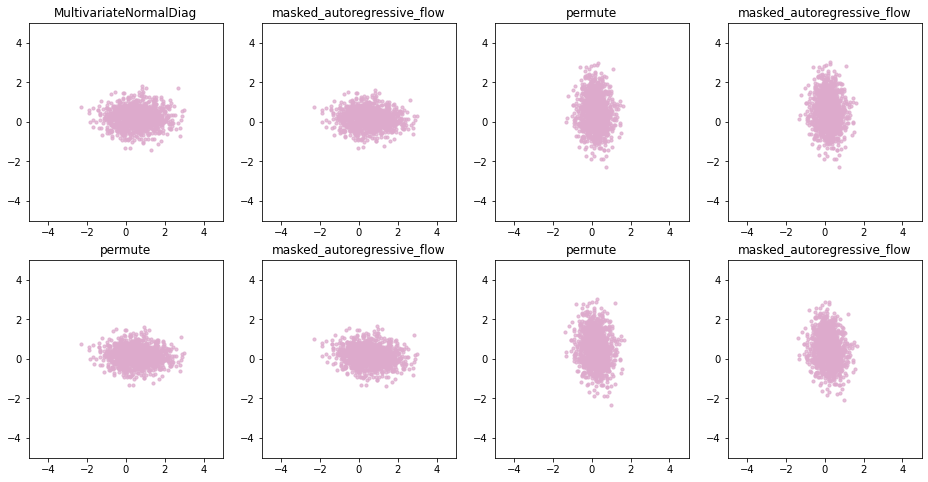

In [34]:
_plot(samples, rows=2, plot_color=color_list[1])

In [35]:
def visualize_training_data(samples, plot_color: str=color_list[0]):
    f, arr = plt.subplots(1, 2, figsize=(20,5))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color=plot_color)
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

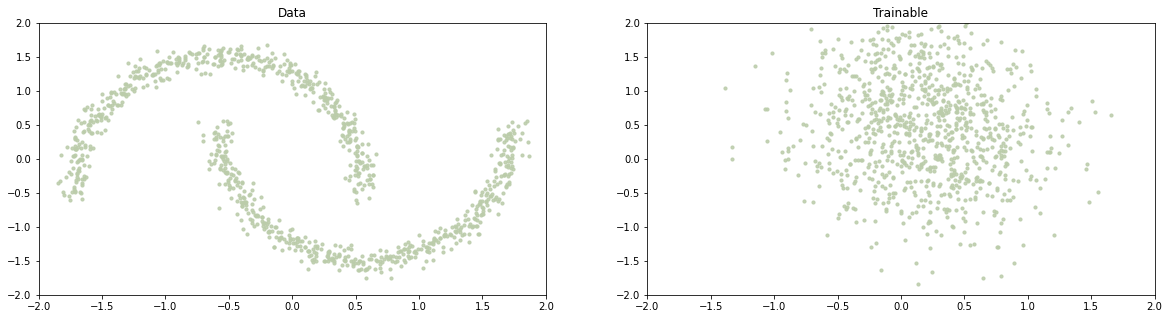

In [36]:
visualize_training_data(samples)

In [38]:
num_epochs = 600
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 200 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 200...
Epoch 400...


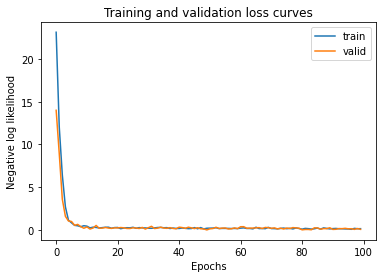

In [39]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [40]:
names, samples = make_samples()

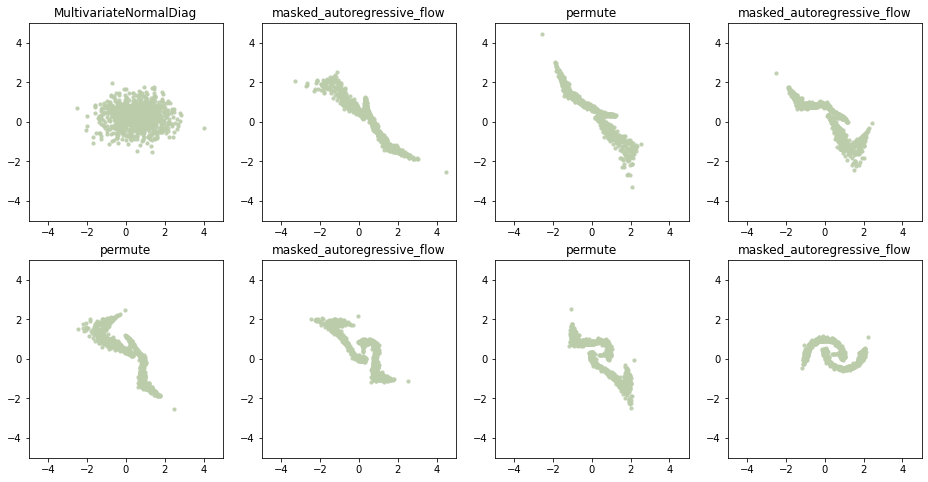

In [41]:
_plot(samples, rows=2)

In [46]:
def visualize_training_data_updated(samples, plot_color: str=color_list[0]):
    f, arr = plt.subplots(1, 2, figsize=(20,5))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color=plot_color)
        arr[i].set_title(names[i])

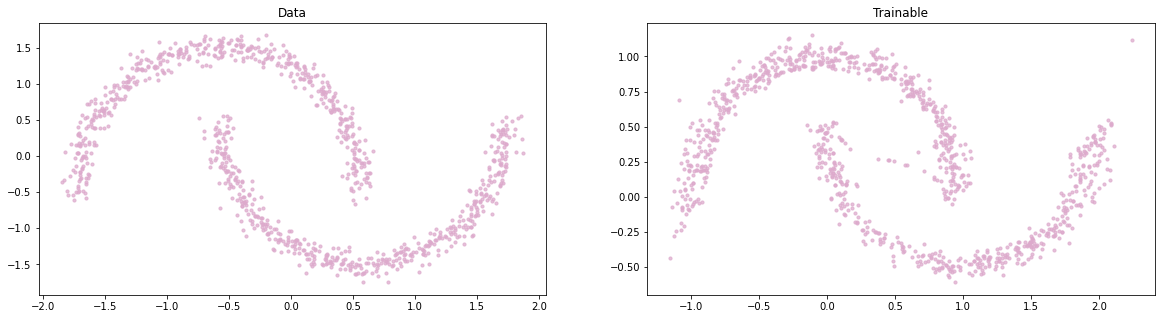

In [48]:
visualize_training_data_updated(samples, plot_color=color_list[1])